# Final Project: Fake News Detection

By Felix Daubner - Hochschule der Medien

Module 'Supervised and Unsupervised Learning' - Prof. Dr.-Ing. Johannes Maucher

## Data Understanding

The data understanding section focuses on getting insights into the scraped data. It is already known that the data only consists of statements, the overarching topic and their respective truth classification.

In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import wordcloud
import altair as alt
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [108]:
def textForWordCloud(data, column):
    return " ".join(i for i in data[column])

def createWordCloud(wc, title):
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off') 
    plt.title(title, fontsize=20)
    plt.show()

To start the data understanding process, the previously scraped data is imported as a pandas DataFrame.

In [133]:
data = pd.read_csv("data/scraped.csv", sep=";", index_col=0)

The DataFrame consists of three columns 'statement', 'issue' and 'truth'.

In [134]:
data.head(10)

,statement,issue,person,channel,truth
0,"Says Sen. Bob Casey, D-Pa., “is trying to chan...",2024-senate-elections,Elon Musk,in an X post,false
1,Says the election results are suspicious becau...,2024-senate-elections,Eric Hovde,"in X, formerly Twitter",false
2,A “ballot dump” around 4 a.m. in Milwaukee sho...,2024-senate-elections,Instagram posts,in an Instagram post,pants-fire
3,“Kari Lake is threatening Social Security and ...,2024-senate-elections,WinSenate,in a Facebook ad,half-true
4,Republican Senate candidate Sam Brown “wants t...,2024-senate-elections,Make the Road Nevada,in an X post,half-true
5,Says opponent Eric Hovde “opposes efforts to n...,2024-senate-elections,Tammy Baldwin,in TV debate,barely-true
6,“Jacky Rosen voted to allow biological men to ...,2024-senate-elections,Sam Brown,in an X post,false
7,"“In Montana, we cherish our public lands. But ...",2024-senate-elections,Jon Tester,in a post on X,false
8,"Sen. Bob Casey ""has voted in lockstep with his...",2024-senate-elections,Dave McCormick,in a debate,false
9,"""Ruben Gallego wanted to defund the police. He...",2024-senate-elections,Kari Lake,in a press conference,false


In [135]:
data.tail(10)

,statement,issue,person,channel,truth
16916,"""Hypocrisy at the Clinton Foundation: Top male...",workers,Donald Trump,in an Instagram post,half-true
16917,"Says ""Elizabeth Warren lied when she says I wa...",workers,Donald Trump,in a tweet,barely-true
16918,"""Closing our state’s wage gap would make a $9 ...",workers,Chris Koster,in a tweet,mostly-true
16919,"Says $15-an-hour proposal in Cleveland is ""the...",workers,Joe Roman,in a Plain Dealer article,true
16920,"""There's only three countries in the entire wo...",workers,Alan Grayson,in an Orlando debate,half-true
16921,"Missouri ""is the state with the lowest paid wo...",workers,Kiki Curls,in following a Missouri Senate Budget Committ...,half-true
16922,"""In 2009 … Hillary Clinton was at the State De...",workers,Lee Camp,"in an episode of ""Redacted Tonight""",half-true
16923,"Says Bernie Sanders ""fundamentally changed the...",workers,Bernie Sanders,in a TV ad,half-true
16924,"""We work longer hours than any people in the i...",workers,Bernie Sanders,in a speech.,barely-true
16925,"Says she will ""work to raise the federal minim...",workers,Hillary Clinton,in a column posted on Medium.com,half-true


16926 rows mean there are 16926 classified statements.

In [136]:
data.shape

(16926, 5)

Currently, all columns are of datatype string. Column 'truth' is going to be mapped to boolean values (0 and 1) in the scope of this project. Column 'issue' is categorical. Also, there are no missing values in the DataFrame.

In [137]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16926 entries, 0 to 16925
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   statement  16926 non-null  object
 1   issue      16926 non-null  object
 2   person     16926 non-null  object
 3   channel    16851 non-null  object
 4   truth      16926 non-null  object
dtypes: object(5)
memory usage: 793.4+ KB


In [138]:
data_statements = data["statement"].apply(len).reset_index()
data_statements.columns = ["row", "characters"]

In [139]:
alt.Chart(data_statements).mark_bar().encode(
    x = alt.X("characters", bin=True, title="Number of characters per statement"), #sort=alt.Sort(field="characters", order="ascending")),
    y = "count()"
).properties(
    title="Distribution of statement length",
    width = 400,
    height = 600,
)

alt.Chart(...)

To understand the distribution of data in terms of issue and truth classifcation, ...

In [140]:
data_truth = data["truth"].value_counts().reset_index()
data_truth.columns = ["classification", "count"]

The distribtution of truth classification is seen below. There are two points which stand out.

Firstly, other than assumed there are more classifcation. 'no-flip', 'half-flip' and 'full-flop' are not known. Is it to be decided whether those classification can be used. 
Secondly, the classification "false" occurs by far the most frequently. This is relevant for the training such as there might be the risk of a biased model as it sees 'false' classification the most. 

Also, to be able to use the data for training a machine learning model, the truth classification have to be boolean values. Thus, the truth classification have to be binary and not multi-class. So all ratings in between true and false have to be assigned to one group. This step is going to part of preprocessing.

In [141]:
alt.Chart(data_truth).mark_bar().encode(
    x = alt.X("classification", sort=alt.Sort(field="count", order="ascending")),
    y = "count"
).properties(
    title="Distribution of 'truth'",
    width = 400,
    height = 600
)

alt.Chart(...)

In [142]:
data_issue = data["issue"].value_counts().reset_index()
data_issue.columns = ["issue", "count"]

The following chart shows the distribution of all statements across the issues. Nearly half the issues have 150 statements which is the upper bound. Those issues are mostly fundamental political issues such as abortion, military, health-care, income, immigration, or housing. However, the issues with less than 150 statements are mostly temporary issues such as katrina (hurricane), 2024 senate elections, or january 6 (US Capitol attack).

In [144]:
alt.Chart(data_issue).mark_bar().encode(
    x = "count",
    y = alt.Y("issue", sort=alt.Sort(field="count", order="descending"))
).properties(
    title="Distribution of 'issue'",
    width = 600,
    height = 1400,
)

alt.Chart(...)

Code for data understanding of persons and channel (separate)
-> person and true / false
-> channel and true / false

In [163]:
data_persons = data["person"].value_counts()[:25].reset_index()
data_persons.columns = ["person", "count"]

In [167]:
alt.Chart(data_persons).mark_bar().encode(
    x = "count",
    y = alt.Y("person", sort=alt.Sort(field="count", order="descending"))
).properties(
    title="Count of statements of 'person'",
    width = 600,
    height = 600,
)

alt.Chart(...)

In [169]:
data_channel = data["channel"].value_counts()[:25].reset_index()
data_channel.columns = ["channel", "count"]

In [170]:
alt.Chart(data_channel).mark_bar().encode(
    x = "count",
    y = alt.Y("channel", sort=alt.Sort(field="count", order="descending"))
).properties(
    title="Count of statements of 'channel'",
    width = 600,
    height = 600,
)

alt.Chart(...)

In [269]:
rem = ["Facebook posts", "Instagram posts", "Viral image", "X posts", "Bloggers", "TikTok posts", "Threads posts", "Social Media", "Chain email"]
persons = [x for x in data_persons["person"].to_list() if x not in rem]
tr = ["full-flop", "half-flip", "no-flip"]

In [270]:
data_grouped_persons = data[data["person"].isin(persons)].groupby(["person", "truth"]).size().reset_index()
data_grouped_persons = data_grouped_persons[~data_grouped_persons["truth"].isin(tr)]
data_grouped_persons.columns = ["person", "truth", "count"]

In [271]:
data_grouped_persons

,person,truth,count
0,Barack Obama,barely-true,14
1,Barack Obama,false,13
4,Barack Obama,half-true,47
5,Barack Obama,mostly-true,52
7,Barack Obama,pants-fire,2
...,...,...,...
106,Tony Evers,false,5
109,Tony Evers,half-true,10
110,Tony Evers,mostly-true,9
112,Tony Evers,pants-fire,1


In [236]:
data_grouped_persons["total"] = data_grouped_persons.groupby("person")["count"].transform("sum")
data_grouped_persons["relative"] = data_grouped_persons["count"] / data_grouped_persons["total"]

In [ ]:
truth_order = ["pants-fire", "false", "barely-true", "half-true", "mostly-true", "true"]
color_order = ["#FF0900", "#FF5B00", "#FFBD44", "#F1FF22", "#00FF08", "#058000"]

alt.Chart(data_grouped_persons).mark_bar().encode(
    x="person",
    y="relative",
    color=alt.Color("truth", scale=alt.Scale(domain=truth_order, range=color_order))
).properties(
    title="Distribution of statement classification by person",
    width=600,
    height=800
)

alt.Chart(...)

Not only shall the persons who made a statement be visualized but also the channel the statements were made on regardless of the person.

In [290]:
channels = data.groupby(["channel"]).size().reset_index()
channels.columns = ["channel", "count"]
channel = channels.sort_values(by="count", ascending=False)["channel"][:25].to_list()

In [291]:
data_grouped_channel = data[data["channel"].isin(channel)].groupby(["channel", "truth"]).size().reset_index()
data_grouped_channel = data_grouped_channel[~data_grouped_channel["truth"].isin(tr)]
data_grouped_channel.columns = ["channel", "truth", "count"]

In [292]:
data_grouped_channel#.sort_values(by="count", ascending=False)

,channel,truth,count
0,in Twitter,barely-true,47
1,in Twitter,false,12
2,in Twitter,half-true,37
3,in Twitter,mostly-true,31
4,in Twitter,pants-fire,3
...,...,...,...
149,in social media posts,pants-fire,15
150,in social media posts,true,2
151,in una publicación en Facebook,barely-true,7
152,in una publicación en Facebook,false,227


In [293]:
data_grouped_channel["total"] = data_grouped_channel.groupby("channel")["count"].transform("sum")
data_grouped_channel["relative"] = data_grouped_channel["count"] / data_grouped_channel["total"]

In [294]:
data_grouped_channel

,channel,truth,count,total,relative
0,in Twitter,barely-true,47,177,0.265537
1,in Twitter,false,12,177,0.067797
2,in Twitter,half-true,37,177,0.209040
3,in Twitter,mostly-true,31,177,0.175141
4,in Twitter,pants-fire,3,177,0.016949
...,...,...,...,...,...
149,in social media posts,pants-fire,15,76,0.197368
150,in social media posts,true,2,76,0.026316
151,in una publicación en Facebook,barely-true,7,270,0.025926
152,in una publicación en Facebook,false,227,270,0.840741


In [295]:
truth_order = ["pants-fire", "false", "barely-true", "half-true", "mostly-true", "true"]
color_order = ["#FF0900", "#FF5B00", "#FFBD44", "#F1FF22", "#00FF08", "#058000"]

alt.Chart(data_grouped_channel).mark_bar().encode(
    x="channel",
    y="relative",
    color=alt.Color("truth", scale=alt.Scale(domain=truth_order, range=color_order))
).properties(
    title="Distribution of statement classification by channel",
    width=600,
    height=800
)

alt.Chart(...)

Now, we want to create a word cloud. A word cloud visualizes the words of a text in different sizes depending on the number of occurrences.
A problem is that so-called 'stop words' like 'and', 'or', 'is' or 'are' appear quite often. To only use the relevant words, all those stop words are eliminated from the word cloud. Based on some manually read statements, some more words / characters are excluded from the wordcloud.

In [145]:
stopwords = wordcloud.STOPWORDS
stopwords.update(["Say", "will", "Says", "U", "S", "US"])

In [146]:
statements = textForWordCloud(data, "statement")

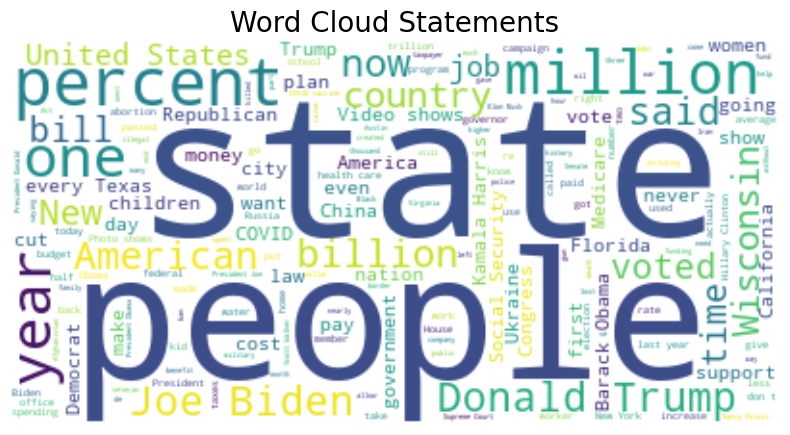

In [147]:
wcloud = wordcloud.WordCloud(background_color="white").generate(statements)

createWordCloud(wcloud, "Word Cloud Statements")

Let's also visualize and compare the wordclouds of true and false statements. Those wordlcouds might already provide some insights into the language which is used for true facts and fake-news.

In [296]:
facts = textForWordCloud(data[data["truth"].isin(["true", "mostly-true"])], "statement")

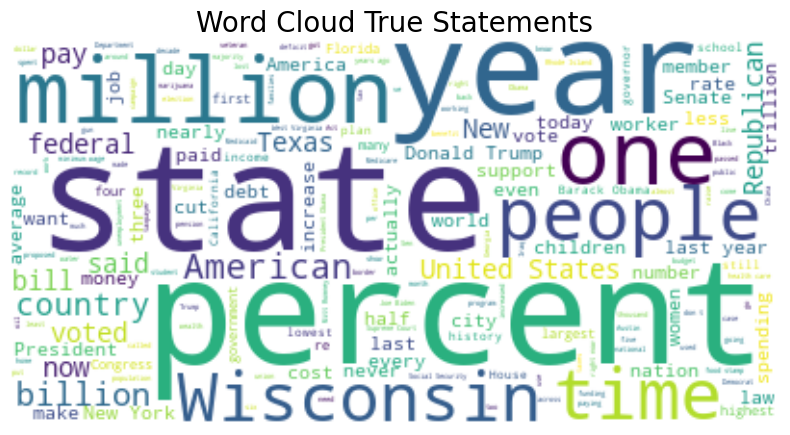

In [297]:
wcloud_facts = wordcloud.WordCloud(background_color="white").generate(facts)

createWordCloud(wcloud_facts, "Word Cloud True Statements")

In [298]:
fake = textForWordCloud(data[data["truth"].isin(["false", "pants-fire"])], "statement")

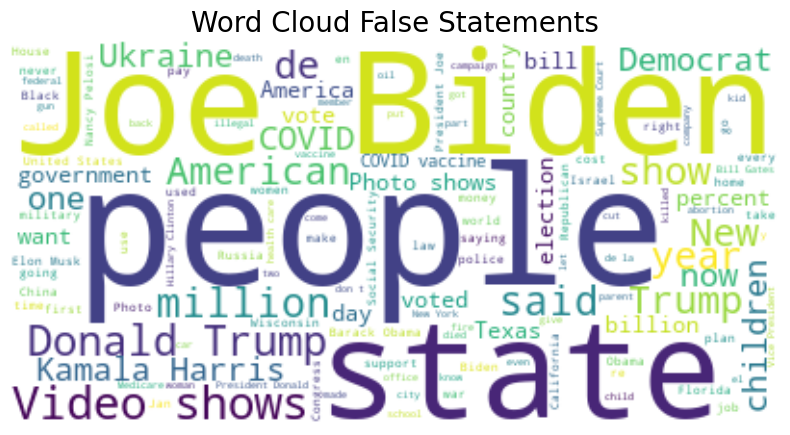

In [299]:
wcloud_fake = wordcloud.WordCloud(background_color="white").generate(fake)

createWordCloud(wcloud_fake, "Word Cloud False Statements")